<a href="https://colab.research.google.com/github/Microvolts1/Learning_NN/blob/main/Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Xây dựng căn bản.


- Sử dụng Neural Network cơ bản đã xây dựng [ở đây](https://github.com/Microvolts1/Learning_NN/blob/main/Fully_connected_NN.ipynb). Ta thêm layer sử dụng phép toán dùng Tích chập(Convolution).

- Phần code dưới để tiện chạy Layer. Có chỉnh sửa so với notebook trước.



In [1]:
import numpy as np
from scipy import signal

In [2]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

In [3]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [4]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [5]:
class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

In [ ]:
class ReLU(Activation):
  def __init__(self):
    def relu(x):
      return x * (x > 0)

    def relu_prime(x):
      return 1 * (x > 0)

    super().__init__(relu, relu_prime)

In [6]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

# II. Convolution Layer.

Nguồn tham khảo chính: https://www.youtube.com/watch?v=Lakz2MoHy6o&t=1131s

## 1. Phép tích chập và phép tương quan chéo (Convolution and Cross-Correlation).

## Tích chập.

- Tích chập ở đây là một phương pháp toán học dùng ma trận (có kích thước thường là 3x3 hoặc N X N) để trích xuất thông tin từ ảnh. 

Minh họa cho kiến trúc CNN
<center>
<img src='https://images.viblo.asia/31db48c4-5df9-409b-8632-85d39196595b.jpeg'>
</center>
Minh họa cho khả năng của tích chập.

<center>
<img  src='https://images.viblo.asia/full/470abaeb-08f4-4b0c-98a9-873bf5764f2a.png'>
</center>

- Đầu tiên, ta chia ảnh thành 3 lớp ma trận tương ứng từng kênh màu của ảnh

<center>
<img src ='https://miro.medium.com/max/1100/1*15yDvGKV47a0nkf5qLKOOQ.png'> 
</center>

- Tiếp đến, ta phát sinh ma trận vuông 3x3(có thể tùy ý nhưng ma trận vuông rất dễ tính toán và tối ưu hơn) gọi là Kernel hoặc Filter. Dùng ma trận đó và ta 'trượt' trên các kênh màu của ảnh để tính toán các thông tin của kênh màu đấy. Bình thường kiến trúc CNN sẽ phát sinh khoảng xấp xỉ 10 loại Kernel khác nhau để phát sinh thông tin nhiều nhất có thể:

<center>
<img src ='https://miro.medium.com/max/1052/1*GcI7G-JLAQiEoCON7xFbhg.gif'>
</center>

- Tích chập tính toán bằng cách lấy vị trí điểm ảnh đang xét và các điểm ảnh xung quanh rồi nhân tương ứng các vị trí với nhau, cuối cùng là tổng lại cái giá trị thu được. Từ đó phát sinh là ma trận mới với kích thước của ảnh nhưng chiều dài và rộng giảm đi(với Kernel 3x3 thì giảm mất 2 đơn vị).

- Để giải quyết vấn đề mất đi 2 đơn vị chiều dài và rộng của ảnh, ta sử dụng kĩ thuật được gọi là padding. Về cơ bản chính là thêm pixels bọc quanh ảnh để giảm mất mát thông tin nhiều nhất có thể. Kĩ thuật phổ biến nhất chính là zero-padding hay bọc lớp pixel mang giá trị không quanh bức ảnh.

<center>
<img src='https://miro.medium.com/max/790/1*nYf_cUIHFEWU1JXGwnz-Ig.gif'>
</center>

- Và tiếp đến là tổng hợp các thông tin từ các kênh màu còn lại cùng các kernel khác nhau.

<center>
<img src='https://miro.medium.com/max/1400/1*ciDgQEjViWLnCbmX-EeSrA.gif'>
</center>



## Phép tương quan chéo.

### Quy ước cơ bản

- Khi chúng ta thực hiện phép tích chập ở trên thì ta cần lưu ý rằng đó là phép tương quan. Vì để đơn giản hóa nên ta hay gọi là tích chập.

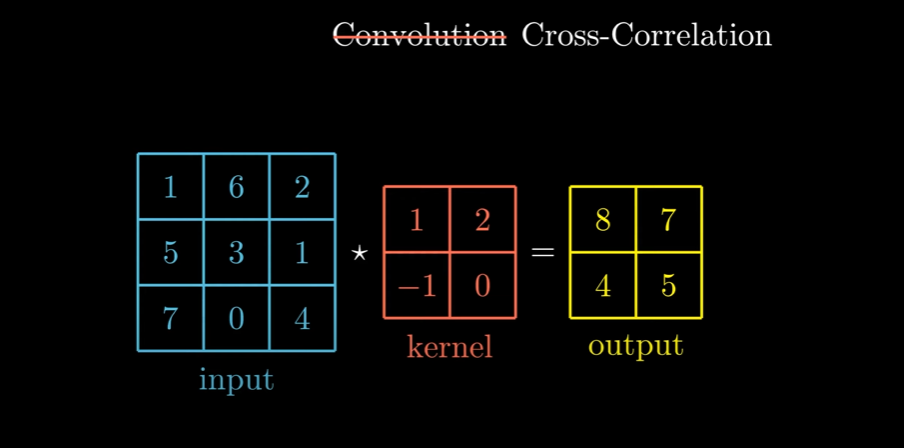

- Tích chập thật sự là việc ta tạo ra một kernel rồi xoay ngược $180^0$ rồi áp dụng lên.

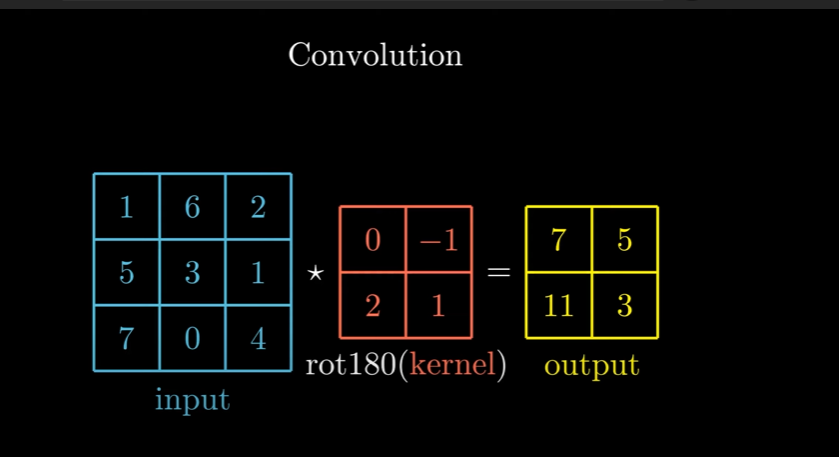

- Ở đây ta kí hiệu hình giống bông tuyết là tích chập. Còn hình ngôi sao là tương quan chéo. 

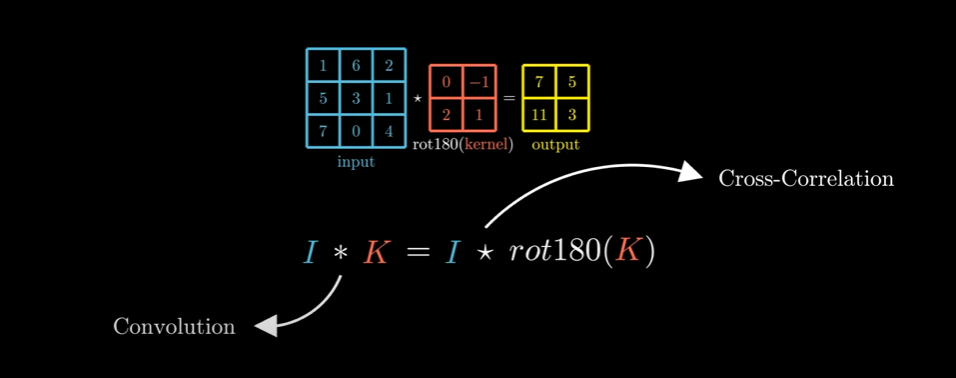

### Khái niệm Cross-Correlation "Full" và "Valid"

- Valid là việc ta nhân tích chập kernel nằm bên 'trong' ma trận input, hay là việc di chuyển kernel sao cho kernel nằm ngay cạnh biên input.

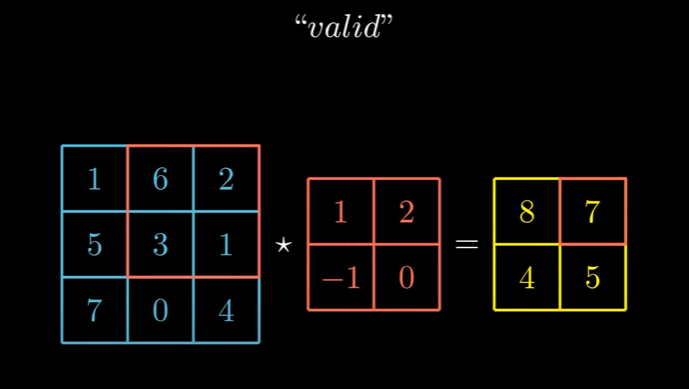

- Full nghĩa là thực hiện nhân tích chập ngay khi kernel 'giao' với phần bất kì của input.

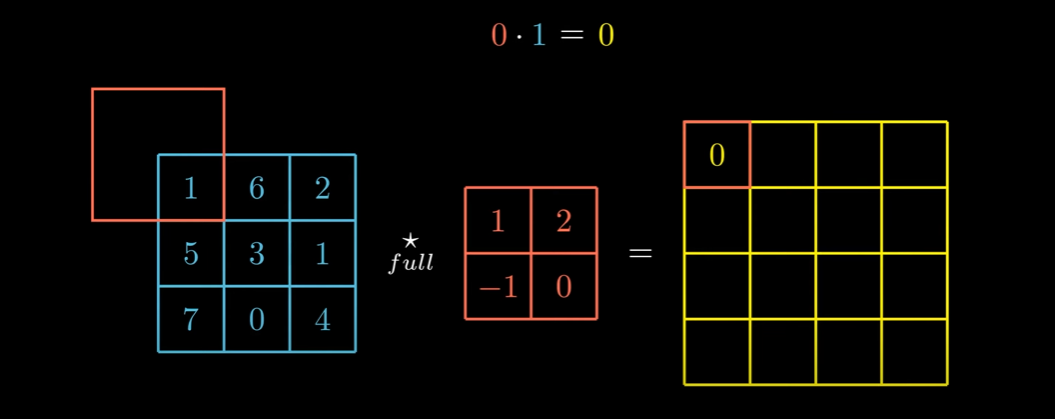

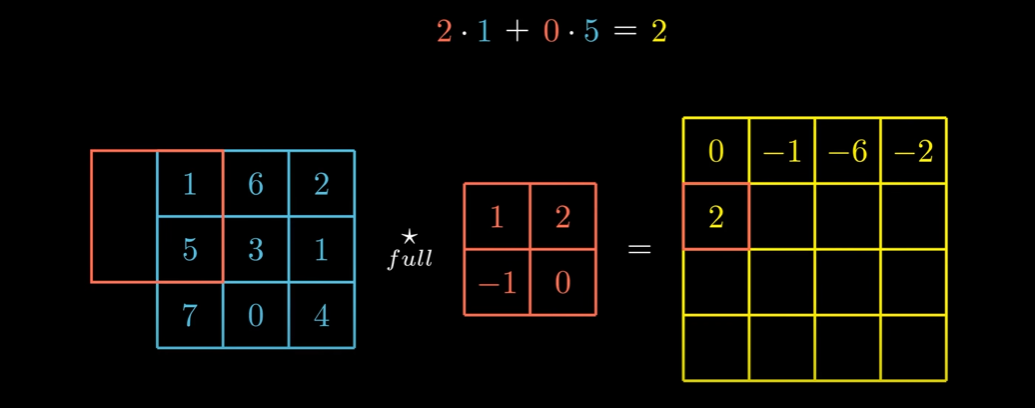

## Chi tiết layer.

### Forward propagation.

- Với nhiều kernel khác nhau. Ta có công thức như sau:

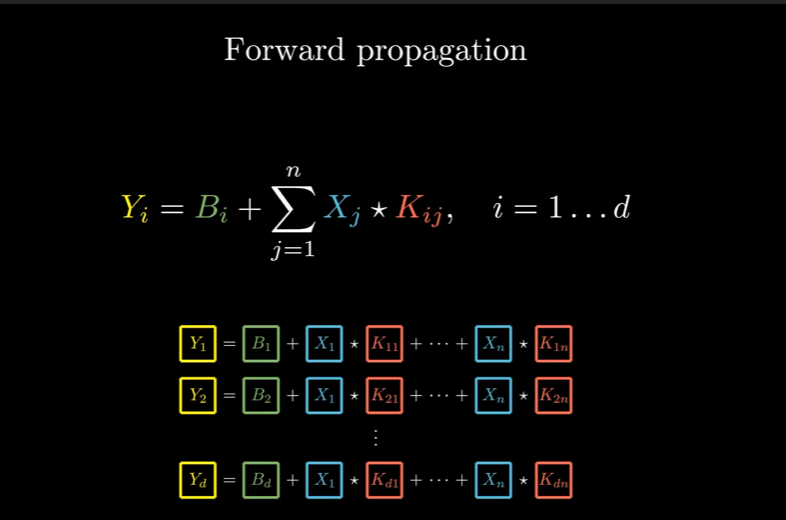

- Ta có thể thực hiện code cho forward như sau:

In [7]:
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
         
        '''
        input_shape: A tupple contain following:
        + input_depth: number of color channels
        + input_height: the height of input
        + input_width: the width of input

        kernel_size: size of kernel matrix: ex: 3 -> 3x3, 5 -> 5x5,...
        depth: number of different kernel, also the depth of output.

        '''
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        pass

### Backward propagation.

- Để cập nhật Kernel và các bias tương ứng. Ta thực hiện đạo hàm vẫn sử dụng chain rule.

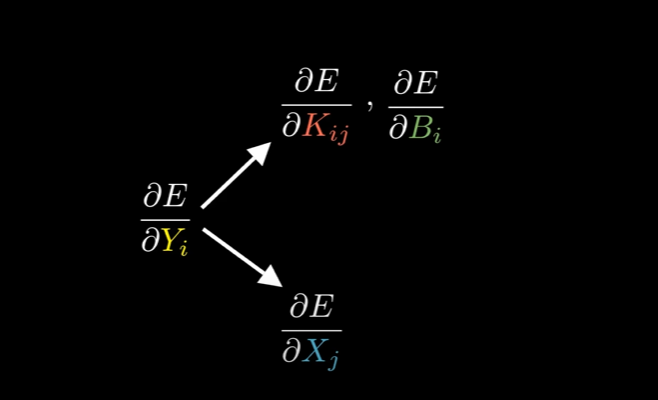

**Đầu tiên ta thực hiện đạo hàm cho** $\frac{\partial{E}}{\partial{K_{ij}}}$

- Đầu tiên ta có công thức từ forward propagation:

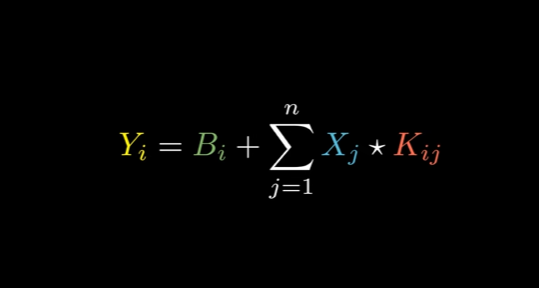

- Để dễ hiểu thì ta đơn giản hóa trên một kernel như dưới:

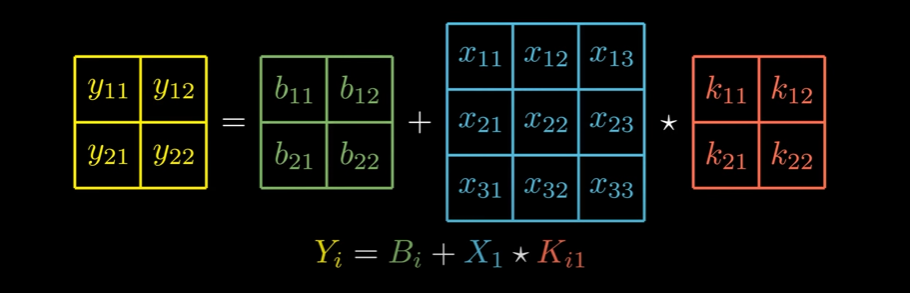

- Và chi tiết hơn ta có như dưới:

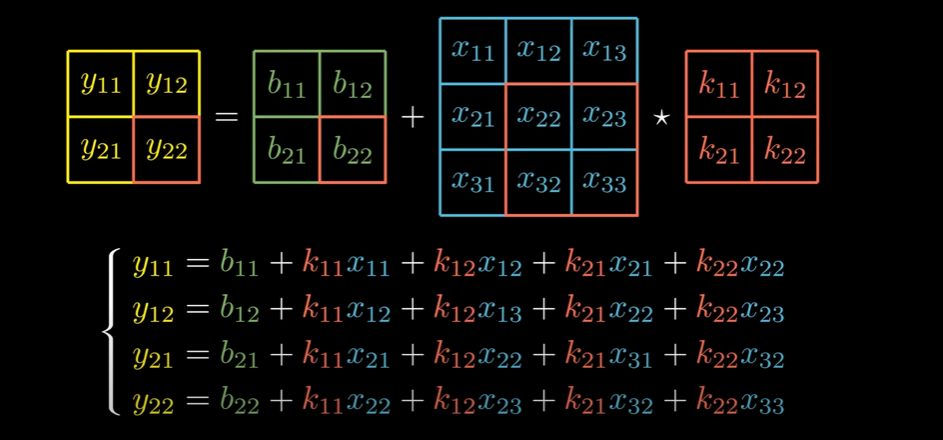

- Với việc đạo hàm trên từng Kernel giả sử ta bắt đầu từ $k_{11}$:

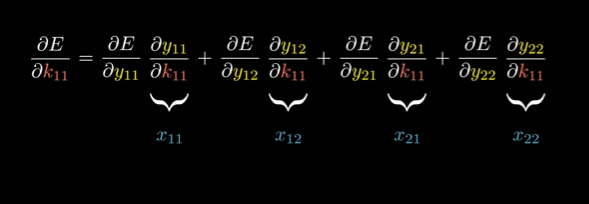

- Từ đó áp dụng với các $k$ còn lại:

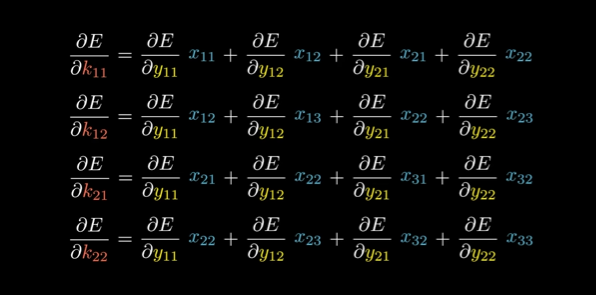

- Và để ý rằng, việc tính toán trên thực chất lại chính là cross-correlation giữa ma trận input với ma trận đạo hàm độ lỗi trên output:

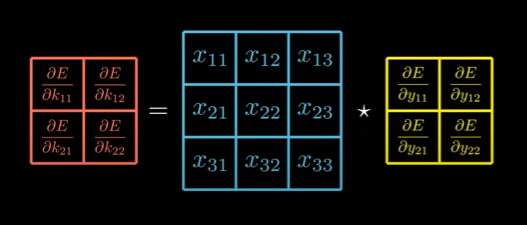

- Và từ đó ta thu được công thức đơn giản như sau: 

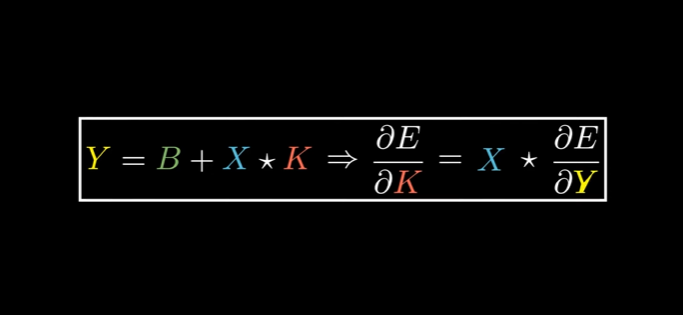

- Tuy nhiên công thức trên chỉ cho 'một' Kernel. Công thức tổng quát của chúng ta lại có nhiều Kernel:

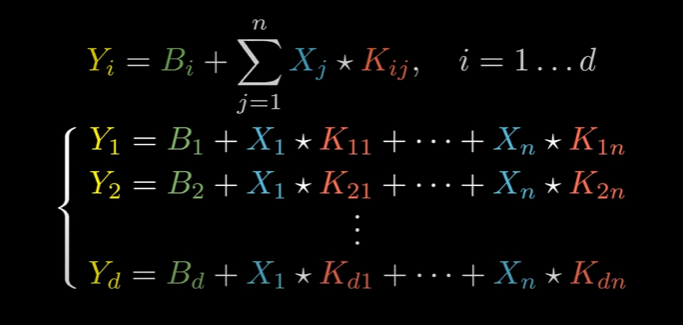

- Giả sử ta tìm đạo hàm độ lỗi với $K_{21}$ hay $\frac{\partial{E}}{\partial{K_{21}}}$

- Ta có thể suy nghĩ tới chain rule nhưng nó không là ý tưởng hay vì khi đó phát sinh ra các đạo hàm với nhiều Kernel khác nhau. Điều này khiến tính toán khó khăn hơn:

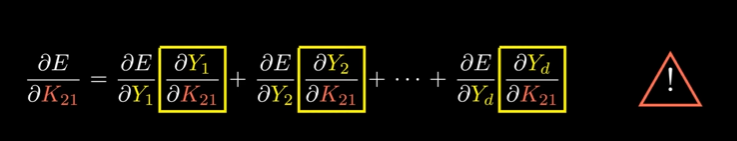

- Để ý tại dòng chỉ chứa $K_{21}$. Ta đã biết rằng đạo hàm của một tổng sẽ bằng tổng các đạo hàm hay $(u + v)' = u' + v'$. Hay khi đạo hàm tại dòng đó thì tại nơi có $K_{21}$ là được xem xét, còn lại là bằng 0 hết.


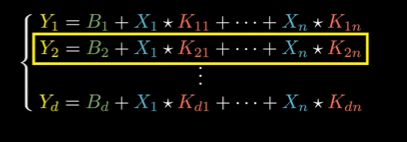

- Thế nên từ công thức đã rút ra được ở trên, ta tính được đạo hàm cho $K_{21}$ như sau:

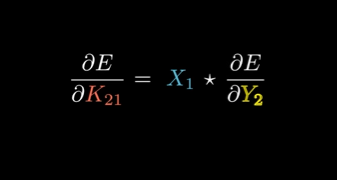

- Hay tổng quan hơn

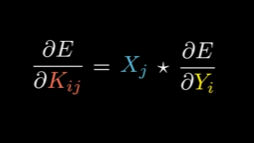

**Tiếp đến ta thực hiện đạo hàm cho** $\frac{\partial{E}}{\partial{B_{ij}}}$

- Sử dụng cách phân tích trên, ta rút ra công thức như sau:

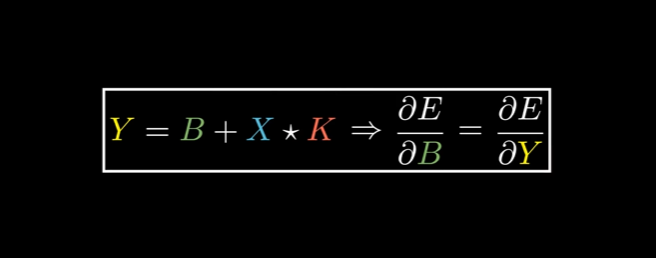

- Và tổng quát ta thu được:

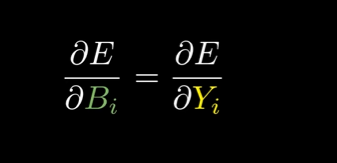

**Tiếp đến ta thực hiện đạo hàm cho** $\frac{\partial{E}}{\partial{X_{ij}}}$

- Giả sử ta đang tính toán như sau:

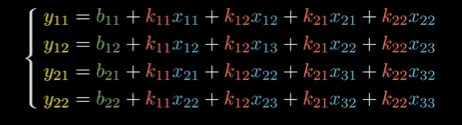

- Giả sử xét trên $x_{11}$ ta sử dụng chain rule như dưới:

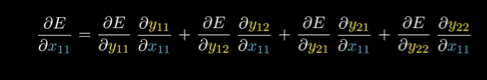

- Và để ý rằng:

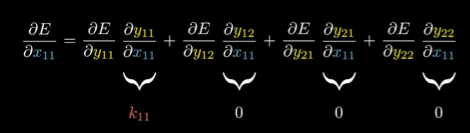

- Tiếp tục cho tất cả $x$ ta thu được:

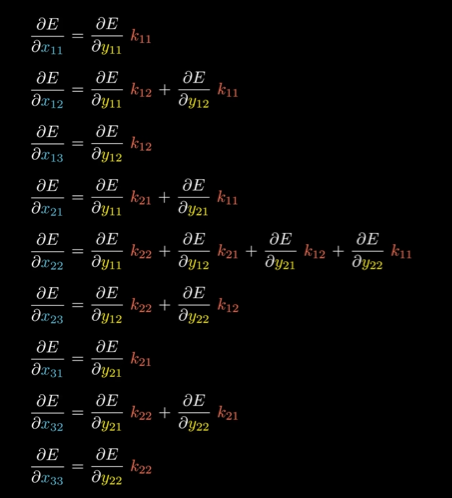

- Nếu bạn tinh ý thì ngay mục có đề cập khái niệm 'full' cross-correlation thì bạn đi đúng hướng rồi đó. Thêm một điều nữa là Kernel ở đây phải xoay $180^0$ hay thực hiện tích chập đúng nghĩa.

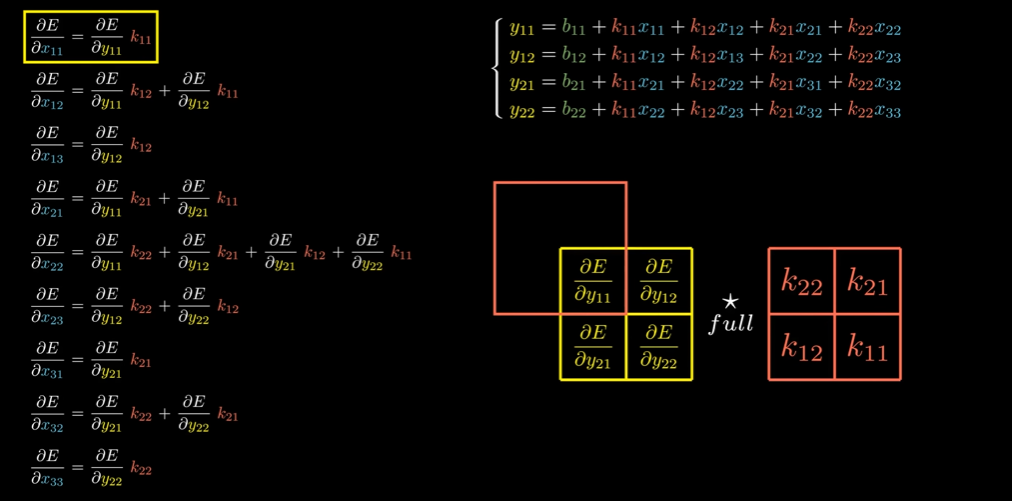

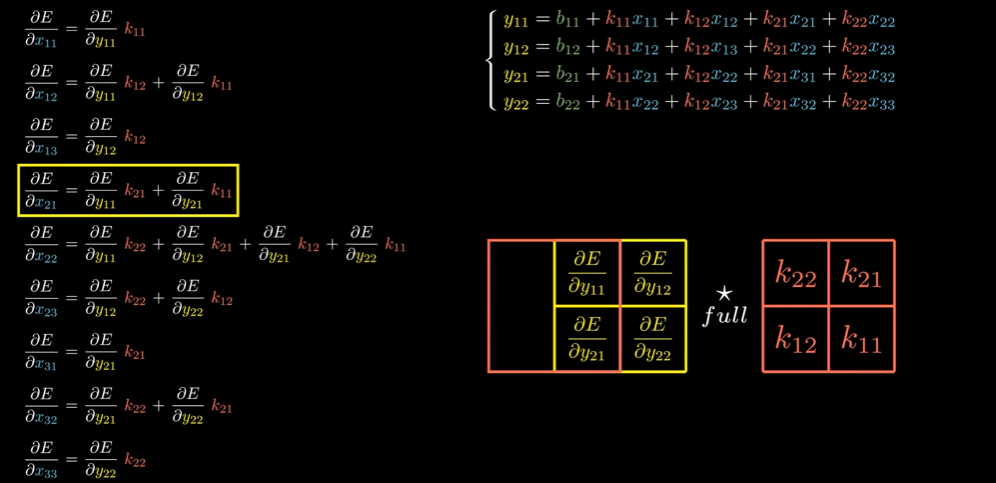

- Vậy từ đó ta rút ra tổng quát như sau:

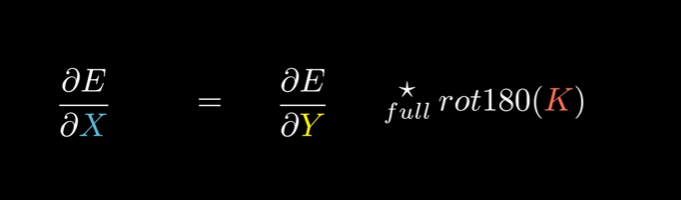

Hay chính xác hơn là định nghĩa chuẩn xác nhất về sử dụng tích chập:

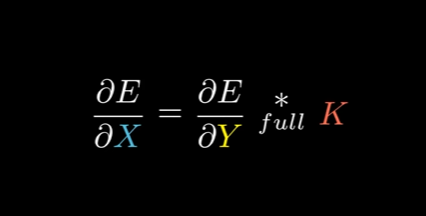

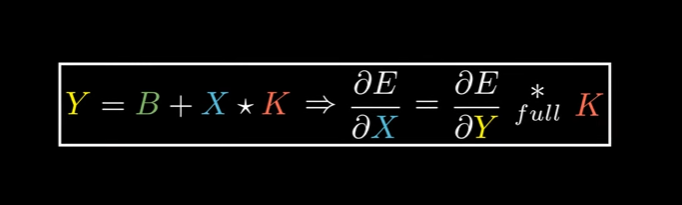

- Và áp dụng trên công thức tổng quát của forward propagation.

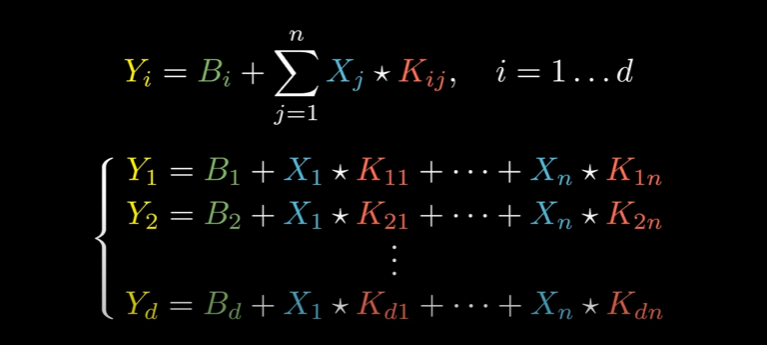

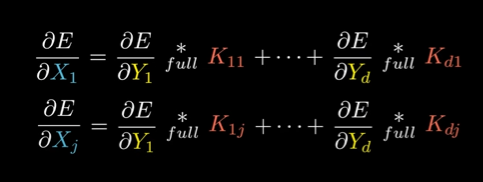

- Và cuối cùng là:

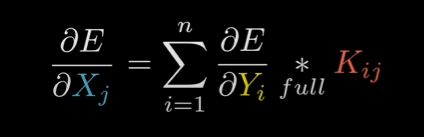

### Ta thực hiện code cho backward propagation như sau:

In [8]:
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        '''
        input_shape: A tupple contain following:
        + input_depth: number of color channels
        + input_height: the height of input
        + input_width: the width of input

        kernel_size: size of kernel matrix: ex: 3 -> 3x3, 5 -> 5x5,...
        depth: number of different kernel, also the depth of output.

        '''
        
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

# III. Reshape Layer.

- Nhiệm vụ rất cơ bản là biến đổi kích thước input thành 1 output có kích thước khác.

In [9]:
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

# IV. Binary Cross Entropy Loss.

- Là 1 layer output đưa ra dự đoán $Y^*$, mỗi $y_i \in Y^*$ với $y_i \in {\{0,1\}}$ so với giá trị thực là $Y$. Đây là kiểu mã hóa hay dùng cho các bài toán phân lớp.(VD: nhận dạng chữ viết tay từ số 0-9 sẽ làm các $y_i$ tại $i$ tương ứng có giá trị là 1, còn lại là 0).

- Công thức toán học để tính sự mất mát(loss) là: 

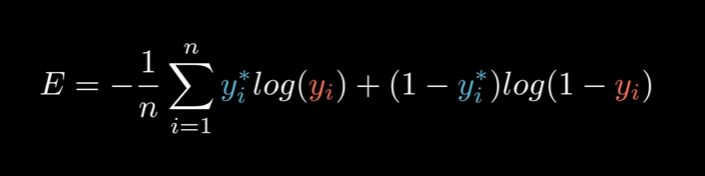

- Ta có code cho hàm mất mát và đạo hàm tương ứng như sau:

In [10]:
def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

# V. Sigmoid Activation.

- Là một dạng khác của hàm kích hoạt, sử dụng natural logarit.

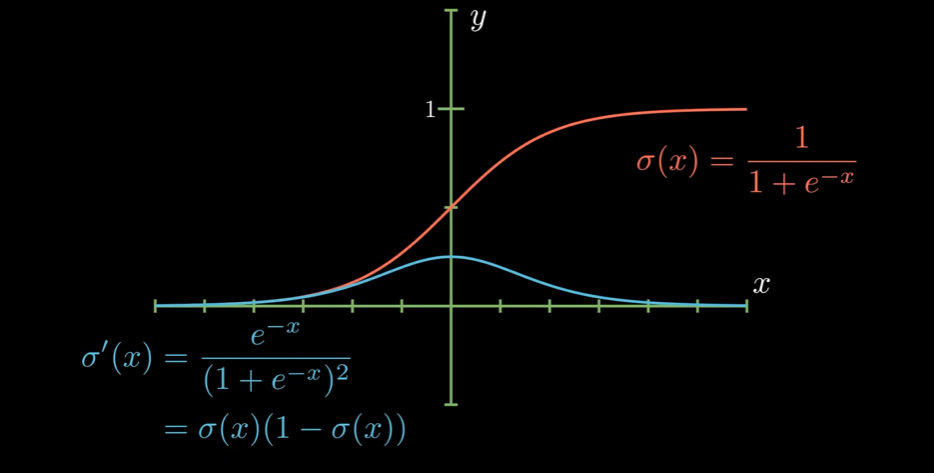

- Ta có code cho layer này như sau:

In [11]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

# VI. Softmax Layer.

- Việc sử dụng softmax sẽ làm output chuẩn hóa có dạng phân phối giống trong xác suất thống kê cũng như đặc tính của softmax nhạy cảm với sự thay đổi của dữ liệu.

In [12]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [13]:
softmax([1,2]) # so với chuẩn hóa thông thường là [0.3333, 0.6666]

array([0.26894142, 0.73105858])

In [14]:
softmax([10,20]) # điều chỉnh đầu vào lên 10 lần thì chuẩn hóa thông thường vẫn là [0.3333, 0.6666]

array([4.53978687e-05, 9.99954602e-01])

## Forward propagation.

- Công thức tổng quát của softmax như sau:


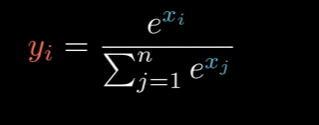

## Backward propagation.

- Về cơ bản vẫn giống như các layer khác. Ta giả sử có đạo hàm độ lỗi với output, từ đó ta cần tìm đạo hàm độ lỗi với input.

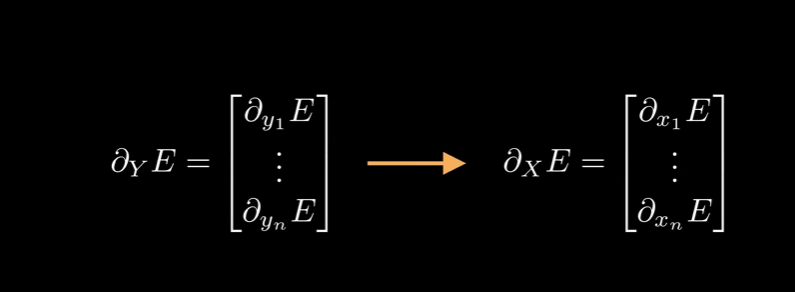

- Sử dụng chain rule cho từng phần tử $x_k$

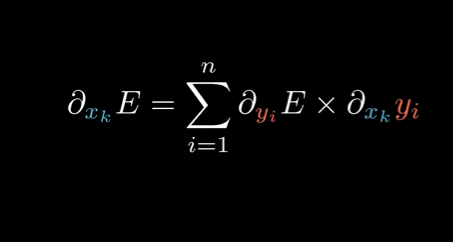

- Sử dụng công thức đạo hàm $(\frac{u}{v})' = \frac{(u'v-uv')}{v^2}$. Ta có:

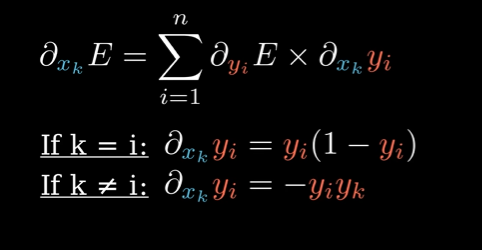

- Ta có thể viết đạo hàm độ lỗi theo input dưới dạng ma trận như sau:

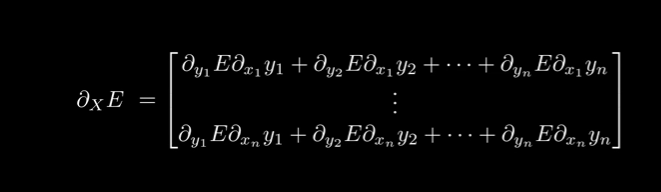

- Sau đó phân tích thành:


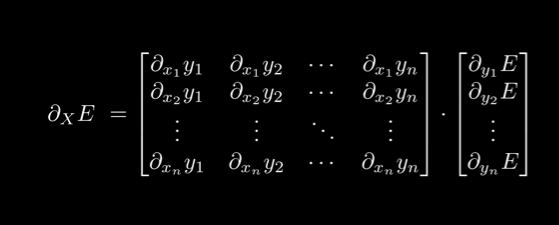

- và từ đó thay vào:


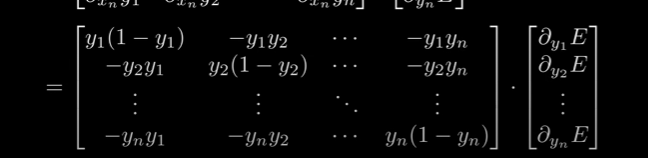

- Nếu để ý từng dòng thì ta có thể thấy rằng dòng 1 thì tất cả luôn có chung nhân tử $y_1$. Tương tự dòng kế tiếp, nên từ đó ta có thể viết lại như sau:

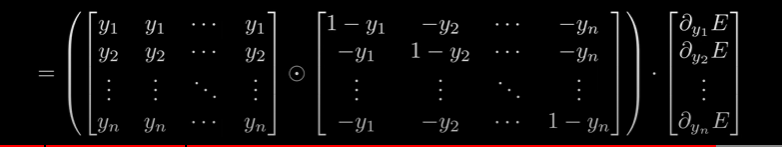

  biểu tượng $\odot$ ám chỉ phép toán [Hamada product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) hay element-wise

- Và để ý ma trận thứ 2 dường như hàng chéo bị trừ bởi 1 và phần còn lại là 0. Đây là phép trừ ma trận giữa ma trận đơn vị và ma trận chuyển vị của ma trận thứ 1:


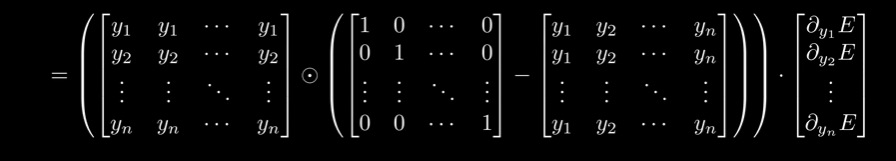

- Kí hiệu ma trận đầu tiên là $M$ thì ta có thể viết gọn như sau:

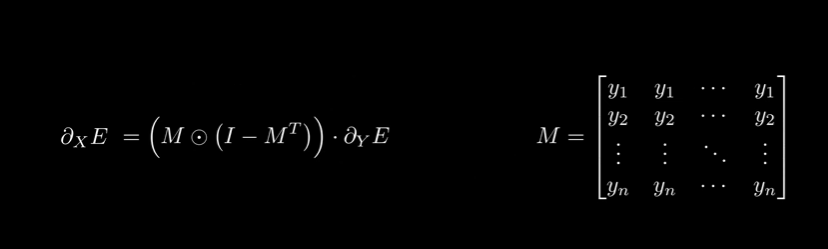

 - Ta có code cho layer như sau:

In [15]:
class Softmax(Layer):
    def forward(self, input):
        self.input = input
        tmp = np.exp(self.input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        # This version is faster than the one presented in the video
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)
        # Original formula:
        # tmp = np.tile(self.output, n)
        # return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

# VII. Pooling Layer

## Max pooling

- Là lấy giá trị lớn nhất với khi kernel di chuyển trên input:

<img src='https://i1.wp.com/nttuan8.com/wp-content/uploads/2019/03/pooling_2.jpg?resize=410%2C302&ssl=1'>

### Forward propagation

- Với forward ta chỉ việc di chuyển kernel với kích thước nhất định.

### Backward propagation

- Khi ta max pooling thì ta không có bất kì trọng số nào cả, thứ ta cần backward là kích thước input trước khi pooling. Vì thế ta cần lưu lại index của các giá trị max và các vị trí còn lại thì chèn giá trị 0.

<img src='https://mukulrathi.com/static/4e96c9ac277c5380d63b470bb3b82f3b/27b8e/pool-backward.png'>

In [16]:
class MaxPoolingLayer(Layer):
  def __init__(self, input_shape, kernel_size, stride):
      #forward variable
      input_depth, input_height, input_width = input_shape
      self.depth = input_depth
      self.stride = stride
      self.input_shape = input_shape
      self.output_shape = (self.depth, int((input_height - kernel_size) / stride) + 1, int((input_width - kernel_size) / stride) + 1)
      self.kernels_size = kernel_size

      #backward variable
      self.prev_input = np.zeros(input_shape) # array have shape before pooling


  def get_pools(self, input, depth):
      # To store individual pools
      pools = []
      
      # Iterate over all row blocks (single block has `stride` rows)
      for i in np.arange(input.shape[0], step=self.stride):
          # Iterate over all column blocks (single block has `stride` columns)
          for j in np.arange(input.shape[1], step=self.stride):
            
              # Extract the current pool
              mat = input[i:i+self.kernels_size, j:j+self.kernels_size]
            
              # Make sure it's rectangular - has the shape identical to the pool size
              if mat.shape == (self.kernels_size, self.kernels_size):
                 # Append to the list of pools
                 pools.append(mat)
                 # store position in prev_input for backward propagation.
                 idx = np.where(input[i:i+self.kernels_size,j:j+self.kernels_size] == np.max(mat)) # find index where max element store in.
                 self.prev_input[depth][i + idx[0][0],j + idx[1][0]] = input[i + idx[0][0],j + idx[1][0]] # store in prev_input.
                
      # Return all pools as a Numpy array
      return np.array(pools)

  def max_pooling(self, input):
      # Total number of pools
      num_pools = input.shape[1]
      # Shape of the matrix after pooling - Square root of the number of pools
      # Cast it to int, as Numpy will return it as float
      # For example -> np.sqrt(16) = 4.0 -> int(4.0) = 4
      tgt_shape = (self.output_shape[1], self.output_shape[2])
      # To store the max values
      pooled = []
      
      # Iterate over all pools
      for pool in input:
          # Append the max value only
          pooled.append(np.max(pool))
          
      # Reshape to target shape
      return np.array(pooled).reshape(tgt_shape)

  def forward(self, input):
      self.input = input
      self.output = np.zeros(self.output_shape)
      for i in range(self.depth):
              pooled = self.get_pools(self.input[i], i)
              self.output[i] = self.max_pooling(pooled)

      return self.output
  
  def backward(self, output_gradient, learning_rate):
      #roll back shape of input 
      return self.prev_input

      

# VII. Thử nghiệm.

## 1. MNIST.

In [17]:
from keras.datasets import mnist
from keras.utils import np_utils

In [18]:
def preprocess_data(x, y, limit):
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    two_index = np.where(y == 2)[0][:limit]
    all_indices = np.hstack((zero_index, one_index, two_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 1, 28, 28)
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y), 3, 1)
    return x, y

In [19]:
# load MNIST from server, limit to 100 images per class since we're not training on GPU
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

11501568/11490434 [==============================] - 0s 0us/step


In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(300, 1, 28, 28)
(300, 3, 1)
(300, 1, 28, 28)
(300, 3, 1)


In [21]:
x_train[0][0].shape

(28, 28)

In [22]:
y_train[0]

array([[0.],
       [1.],
       [0.]], dtype=float32)

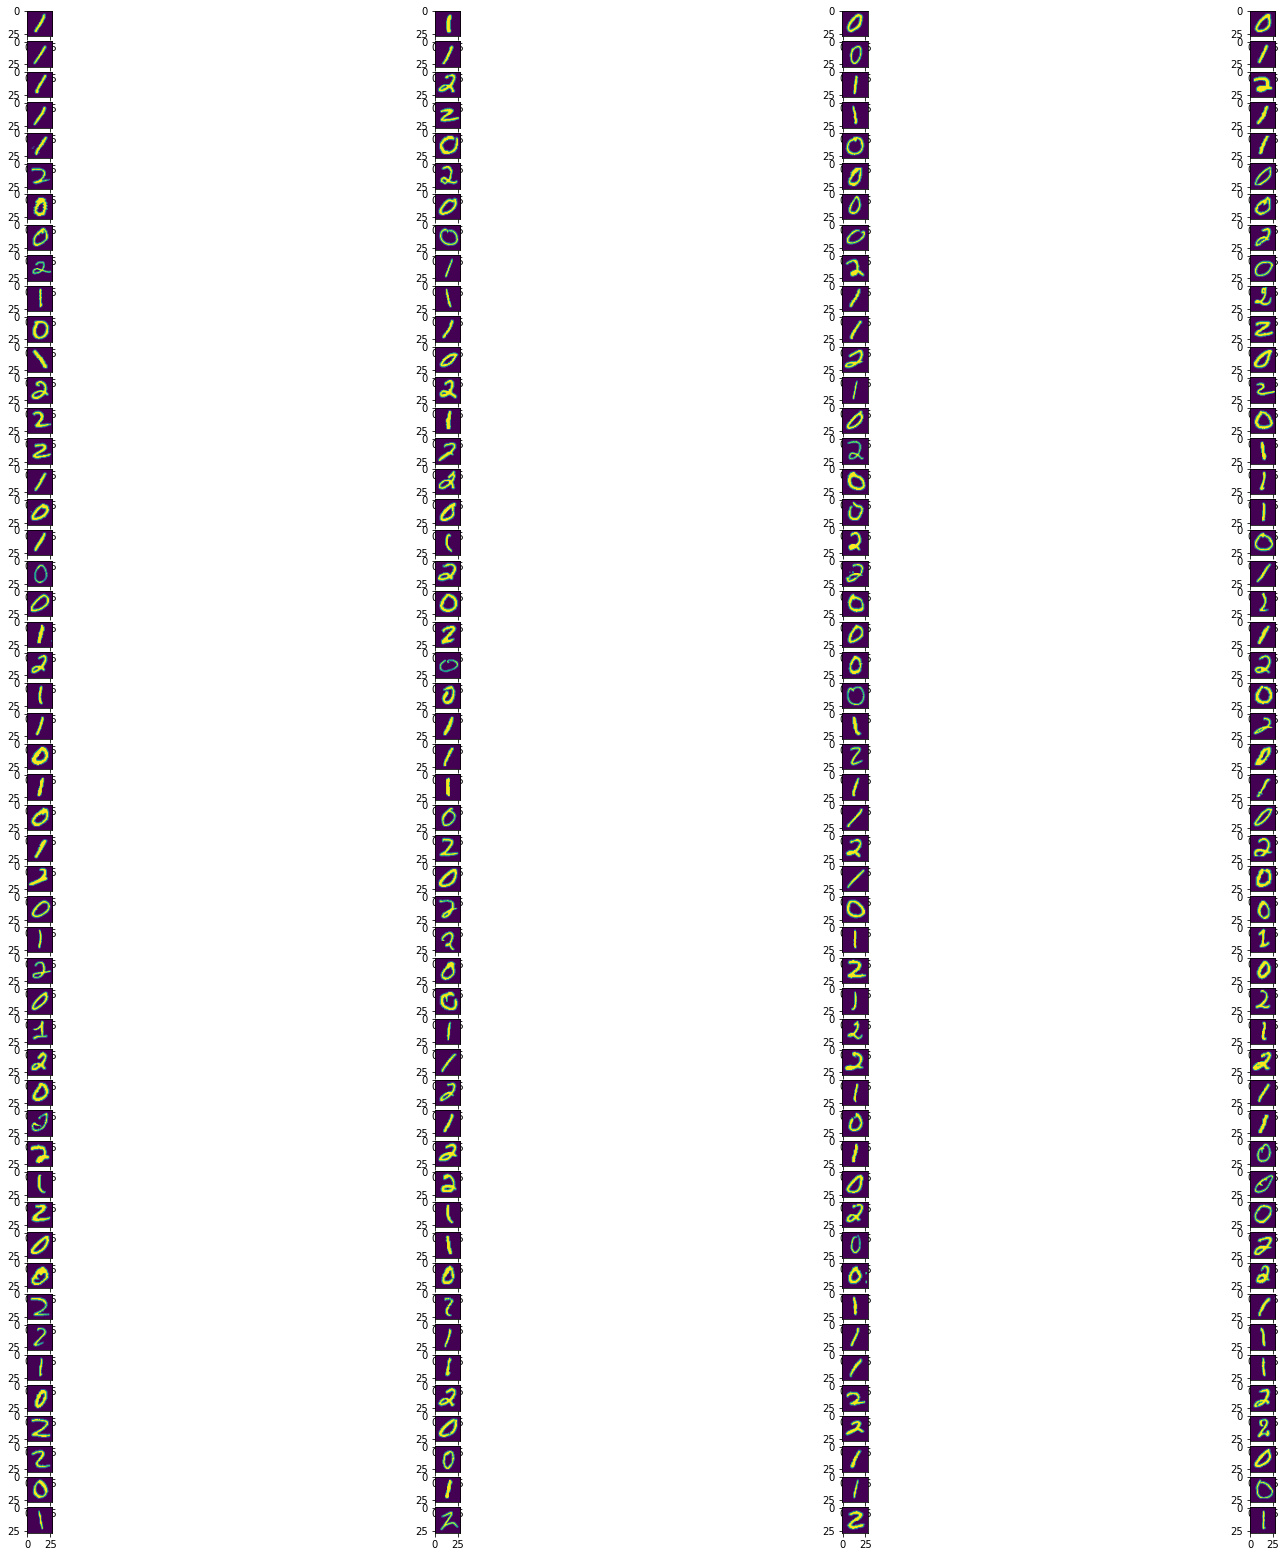

In [24]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(28, 28))
columns = 4
rows = 50
for i in range(0, columns*rows):
    img = x_train[i][0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

In [25]:
# neural network
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    MaxPoolingLayer((5,26,26),2, 2),
    Convolutional((5,13,13), 3, 5),
    Sigmoid(),
    Reshape((5, 11, 11), (5 * 11 * 11, 1)),
    Dense(5 * 11 * 11, 100),
    Sigmoid(),
    Dense(100, 3),
    Softmax()
]

In [26]:
%%time
# train
train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    epochs=20,
    learning_rate=0.1
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


1/20, error=0.6389037797814769
2/20, error=0.3227185446517749
3/20, error=0.22845717151321304
4/20, error=0.21459152023232586
5/20, error=0.23779933564778086
6/20, error=0.22573832461735777
7/20, error=0.20041214735971807
8/20, error=0.2033784259407086
9/20, error=0.2491199747243817
10/20, error=0.24469560669426982
11/20, error=0.23270574854119494
12/20, error=0.1985780451622645
13/20, error=0.2083060766840138
14/20, error=0.14469987052706573
15/20, error=0.1350125959924028
16/20, error=0.15030934835684046
17/20, error=0.13388895821383195
18/20, error=0.10583240089081788
19/20, error=0.10054106834280997
20/20, error=0.09598887831684429
CPU times: user 3min 29s, sys: 2min 40s, total: 6min 9s
Wall time: 3min 9s


In [27]:
# test
true_label = 0
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")
    if np.argmax(output) == np.argmax(y):
      true_label += 1

pred: 1, true: 1
pred: 1, true: 1
pred: 2, true: 2
pred: 1, true: 1
pred: 1, true: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.



pred: 2, true: 2
pred: 1, true: 1
pred: 2, true: 2
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 2, true: 2
pred: 1, true: 2
pred: 2, true: 2
pred: 1, true: 2
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 2, true: 2
pred: 1, true: 1
pred: 0, true: 0
pred: 2, true: 2
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 2, true: 2
pred: 0, true: 0
pred: 2, true: 2
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 2, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 2, true: 2
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 2, true: 2
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 2, true: 2
pred: 2, true: 2
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true

In [28]:
#Score:
print(f"Score: {true_label/len(x_test)} on predict true:{true_label} vs true:{len(x_test)}")

Score: 0.9466666666666667 on predict true:284 vs true:300
